In [1]:
using ApproxFun
using SpecialFunctions

using LinearAlgebra
using SparseArrays

include("../src/Chebyshev.jl")
import .Chebyshev as CH

import Plots
using Plots

# use PyCall
using PyCall

# import python library
#@pyimport qnm

In [2]:
@pyimport qnm

# Teukolsky Radial Equation

In [3]:
function radial_operator(
    nr::Integer,
    s::Integer,
    m::Integer,
    a::T,
    bhm::T,
    om::Complex{T},
    gamma::Complex{T},
    rmin::T,
    rmax::T,
) where {T<:Real}
    d = rmin..rmax;
    D1 = Derivative(d);
    D2 = D1^2;
    x = Fun(identity,d);

    A = (
        (2 * im) * om - 2 * (1 + s) * x +
        2 * (im * om * ((a^2) - 8 * (bhm^2)) + im * m * a + (s + 3) * bhm) * x^2 +
        4 * (2 * im * om * bhm - 1) * (a^2) * x^3
    )
    B = (
        (((a^2) - 16 * (bhm^2)) * (om^2) + 2 * (m * a + 2 * im * s * bhm) * om) +
        2 *
        (
            4 * ((a^2) - 4 * (bhm^2)) * bhm * (om^2) +
            (4 * m * a * bhm - 4 * im * (s + 2) * (bhm^2) + im * (a^2)) * om +
            im * m * a +
            (s + 1) * bhm
        ) *
        x +
        2 * (8 * (bhm^2) * (om^2) + 6 * im * bhm * om - 1) * (a^2) * x^2
    )
    return (-(x^2 - 2 * bhm * x^3 + (a^2) * x^4) * D2 + A * D1 + (B + gamma))[1:nr,1:nr]
end;

In [37]:
# input params

nr = 120
s = -2;
l = 2;
m = 2;
n = 15;
T=Float64
a = T(0.999)
bhm = T(1)

rmin = T(0) ## location of future null infinity (1/r = ∞)
rmax = abs(a) > 0 ? (bhm / (a^2)) * (1 - sqrt(1 - ((a / bhm)^2))) : 0.5 / bhm

0.9572032715275677

In [38]:
mode_seq = qnm.modes_cache(s=s,l=l,m=m,n=n);
omega, gamma, C = mode_seq(a=a);

In [39]:
rs = CH.cheb_pts(rmin,rmax,nr);

In [40]:
M = radial_operator(nr,s,m,a,bhm,omega,gamma,rmin,rmax);

In [41]:
null = nullspace(Matrix(M),rtol=1e-14);

In [42]:
null

120×1 Matrix{ComplexF64}:
    0.28598562510484105 - 0.0im
     -0.534010067305892 - 0.15103040607329585im
    0.27072692223028744 + 0.423661703171871im
    0.18602016318017184 - 0.3714176440463853im
   -0.30871824857957264 - 0.05137750855218968im
   -0.01257318797090573 + 0.22006165355544383im
     0.1480293979472344 + 0.01541081933790589im
   0.026838300116104913 - 0.09397305032177927im
   -0.05350083364151252 - 0.03319790997194151im
   -0.03193616122775107 + 0.02442638071591763im
  0.0054460098427184245 + 0.024947671765187113im
   0.015467619073511227 + 0.004551692188935655im
   0.007564670725458383 - 0.006791427170504098im
                        ⋮
     5.759281940243e-16 + 5.204170427930421e-18im
  5.551115123125783e-16 + 2.7755575615628914e-16im
  7.494005416219807e-16 - 1.0581813203458523e-16im
 2.8275992658421956e-16 + 2.96637714392034e-16im
  5.197665214895508e-16 - 3.5648567431323386e-16im
 3.8125969395452763e-16 + 3.434752482434078e-16im
 1.8388068845354155e-16 - 4.0419056990

In [43]:
vect = CH.to_real(null[:,1]);

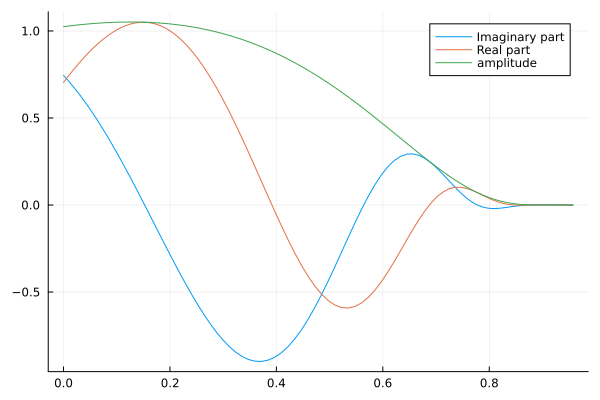

In [44]:
Plots.plot(rs,[v.im for v in vect],label="Imaginary part")
Plots.plot!(rs,[v.re for v in vect],label="Real part")
Plots.plot!(rs,[abs(v) for v in vect],label="amplitude")


# Save the resulting files

In [47]:
function save_to_file!(
    prename::String,
    n::Integer,
    l::Integer,
    m::Integer,
    a::T,
    omega::Complex{T},
    lambda::Complex{T},
    vr::Vector{<:Complex{T}},
    rs::Vector{<:T},
) where {T<:Real}
    fname = "$(pwd())/qnmfiles/$(prename)_a$(a)_l$(l)_m$(m)_n$(n)"
    HDF5.h5open("$fname.h5", "cw") do file
        g = HDF5.create_group(file, "[a=$(convert(Float64,a)),l=$(convert(Int64,l))]")
        g["nr"] = convert(Int64, nr)
        g["nl"] = convert(Int64, nl)
        g["omega"] = convert(ComplexF64, omega)
        g["lambda"] = convert(ComplexF64, lambda)
        g["radial_func"] = [convert(ComplexF64, v) for v in vr]
        g["rvals"] = [convert(Float64, v) for v in rs]
    end
    return nothing
end;